In [113]:
import pandas as pd
import re
import spacy
import nltk
from nltk.corpus import stopwords
from langdetect import detect
from language_detector import detect_language

# Carica i dati
url = 'https://raw.githubusercontent.com/zfz/twitter_corpus/master/full-corpus.csv'
df = pd.read_csv(url)
data = df['TweetText'].tolist()


stop_words_dict = {
    'ar': set(stopwords.words('arabic')),      # Arabo
    'de': set(stopwords.words('german')),      # Tedesco
    'en': set(stopwords.words('english')),     # Inglese
    'es': set(stopwords.words('spanish')),     # Spagnolo
    'fr': set(stopwords.words('french')),      # Francese
    'it': set(stopwords.words('italian')),     # Italiano
    'pt': set(stopwords.words('portuguese')),  # Portoghese
    'ru': set(stopwords.words('russian')),      # Russo
    'tr': set(stopwords.words('turkish')),      # Turco
    'zh-cn': set(stopwords.words('chinese')),      # Cinese
}

# Funzione per pulire i tweet
def clean_tweet(text):
    text =re.sub(r'http\S+|https\S+', '', tweet) # Rimuovi link
    text = re.sub(r'@(\w+)', r'\1', text)    # Rimuovi menzioni (@username)
    text = re.sub(r'#\w+', '', text) # Rimuovi hashtag
    text = re.sub(r'[^\w\s]', '', text)     # Rimuovere punteggiatura, numeri e simboli
    text = text.lower() 
    
    return text

# Rimozione stopwords
def remove_stopwords(text, lang):
    if lang in stop_words_dict:
        stop_words = stop_words_dict[lang]
        return ' '.join([word for word in text.split() if word.lower() not in stop_words])
    else:
        return text

In [114]:
# Pre-elaborazione dei tweet
data_cleaned = []
for tweet in data:
    try:
        # Rileva la lingua
        lang = detect(tweet)
        # Pulizia del tweet
        cleaned_tweet = clean_tweet(tweet)
        # Rimozione stop words in base alla lingua rilevata
        cleaned_tweet = remove_stopwords(cleaned_tweet, lang)
        data_cleaned.append(cleaned_tweet)
    except:
        continue  # Ignora tweet con errore nella rilevazione della lingua
print("Tweet originale:", data[:10])
print("Tweet pulito:", data_cleaned[:10])

Tweet originale: ['Now all @Apple has to do is get swype on the iphone and it will be crack. Iphone that is', '@Apple will be adding more carrier support to the iPhone 4S (just announced)', "Hilarious @youtube video - guy does a duet with @apple 's Siri. Pretty much sums up the love affair! http://t.co/8ExbnQjY", '@RIM you made it too easy for me to switch to @Apple iPhone. See ya!', 'I just realized that the reason I got into twitter was ios5 thanks @apple', "I'm a current @Blackberry user, little bit disappointed with it! Should I move to @Android or @Apple @iphone", 'The 16 strangest things Siri has said so far. I am SOOO glad that @Apple gave Siri a sense of humor! http://t.co/TWAeUDBp via @HappyPlace', 'Great up close & personal event @Apple tonight in Regent St store!', 'From which companies do you experience the best customer service aside from @zappos and @apple?', 'Just apply for a job at @Apple, hope they call me lol']
Tweet pulito: ['apple get swype iphone crack iphone', 'ap

In [115]:
# Lemmatizzazione - Carica modelli per ogni lingua
nlp_models = {
    'en': spacy.load("en_core_web_sm"),
}

def lemmatize_text(text, lang):
    if lang in nlp_models:
        doc = nlp_models[lang](text)
        return ' '.join([token.lemma_ for token in doc if not token.is_stop])
    return text  # Restituisce il testo originale se non è supportato

# Lemmatizzazione dei dati puliti
data_lemmatized = []
for tweet in data_cleaned:
    try:
        lang = detect(tweet)
        lemmatized_tweet = lemmatize_text(tweet, lang)
        data_lemmatized.append(lemmatized_tweet)
    except:
        continue 
        
data_lemmatized = [tweet for tweet in data_lemmatized if isinstance(tweet, str) and tweet]
print("Tweet lemmatizzati:", data_lemmatized[:10])
print("Numero di tweet lemmatizzati:", len(data_lemmatized))

Tweet lemmatizzati: ['apple swype iphone crack iphone', 'apple add carrier support iphone 4s announce', 'hilarious youtube video guy duet apple siri pretty much sums love affair', 'rim easy switch apple iphone ya', 'realize reason get twitter ios5 thanks apple', 'm current blackberry user little bit disappointed android apple iphone', '16 strangest things siri said far sooo glad apple gave siri sense humor via happyplace', 'great close personal event apple tonight regent st store', 'companies experience best customer service aside zappos apple', 'apply job apple hope lol']
Numero di tweet lemmatizzati: 5062


In [116]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [117]:
import matplotlib.pyplot as plt

# Visualizzare i topic in un grafico a barre
def plot_topics(topics, top_n=10):
    # Mostra solo i primi 10 topic
    for topic_id, topic_words in list(topics.items())[:10]:
        words = [word for word, _ in topic_words[:top_n]]
        freqs = [freq for _, freq in topic_words[:top_n]]
        
        plt.figure(figsize=(10, 5))
        plt.barh(words, freqs)
        plt.title(f'Topic {topic_id}')
        plt.xlabel('Frequenza')
        plt.ylabel('Parole')
        plt.gca().invert_yaxis()  # Inverte l'asse y per avere il topic più importante in alto
        plt.show()


In [118]:
from bertopic import BERTopic
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

b_topic_model = BERTopic()
b_topics, probabilities = b_topic_model.fit_transform(data_lemmatized)

b_topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,2114,-1_rt_apple_not_app,"[rt, apple, not, app, get, new, google, thank,...",[rt neowinfeed google show new ice cream sandw...
1,0,116,0_een_je_op_van,"[een, je, op, van, voor, ik, naar, dat, en, zijn]",[je moet er wel een mechanische papegaai voor ...
2,1,113,1_update_ios5_io_restore,"[update, ios5, io, restore, icloud, upgrade, a...",[apple not itune update wanna update iphone io...
3,2,98,2_apple_mouse_fuck_bad,"[apple, mouse, fuck, bad, thank, apparently, s...","[apple, apple, apple]"
4,3,96,3_nexus_galaxy_samsung_uk,"[nexus, galaxy, samsung, uk, google, prime, ca...",[доступна официальная googleстраница galaxy ne...
...,...,...,...,...,...
92,91,11,91_declarar_gates_caso_llamado,"[declarar, gates, caso, llamado, antiguo, mono...","[bill gates llamado declarar antiguo caso, bil..."
93,92,11,92_nuevo_nueva_gtxdlt_esperenlo,"[nuevo, nueva, gtxdlt, esperenlo, nelsonfenc, ...","[nuevo 40, nelsonfenc recupere el para de nuev..."
94,93,11,93_virtualsystem_hp_virtualfat_azure,"[virtualsystem, hp, virtualfat, azure, private...","[virtualsystem late solution hp microsoft, sta..."
95,94,11,94_webgl_bookcase_infinite_ui,"[webgl, bookcase, infinite, ui, abstract, limi...","[rt dalmaer webgl infinite bookcase ui, webgl ..."


In [119]:
bert_topics = b_topic_model.get_topics()
# Preparare i dati per Gensim
topic_w = [doc.split() for doc in data_lemmatized]
dictionary = Dictionary(topic_w)

In [120]:
from g2t.graph2topictm import evaluate

td_score, cv_score, npmi_score = evaluate(data_lemmatized, b_topics, bert_topics)
print(f"Diversità dei temi: {td_score}, Coerenza c_v: {cv_score}, Coerenza NPMI: {npmi_score}")

Diversità dei temi: 0.8608247422680413, Coerenza c_v: 0.791945854549016, Coerenza NPMI: 0.1529731964764308


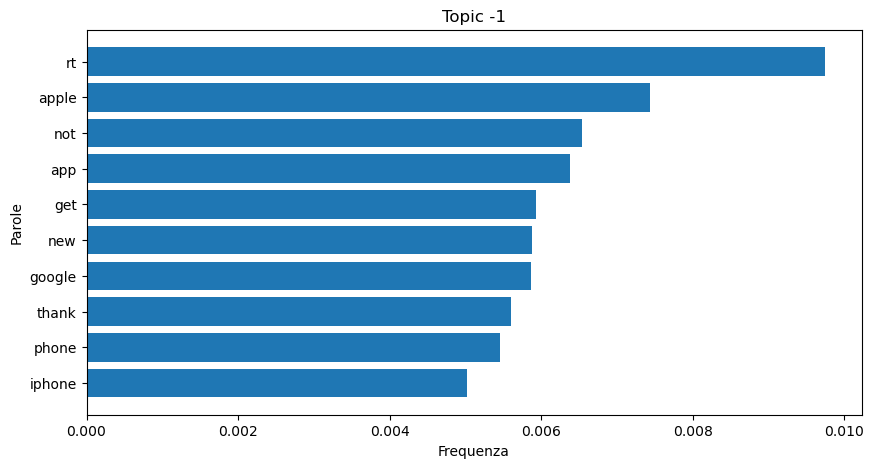

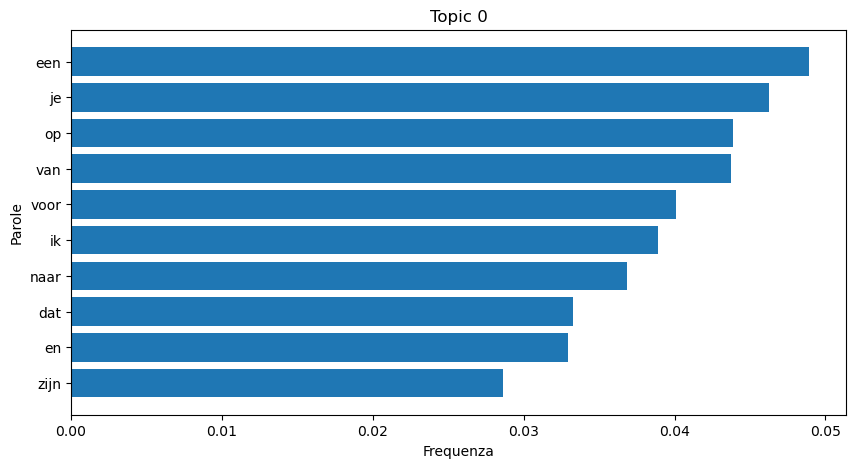

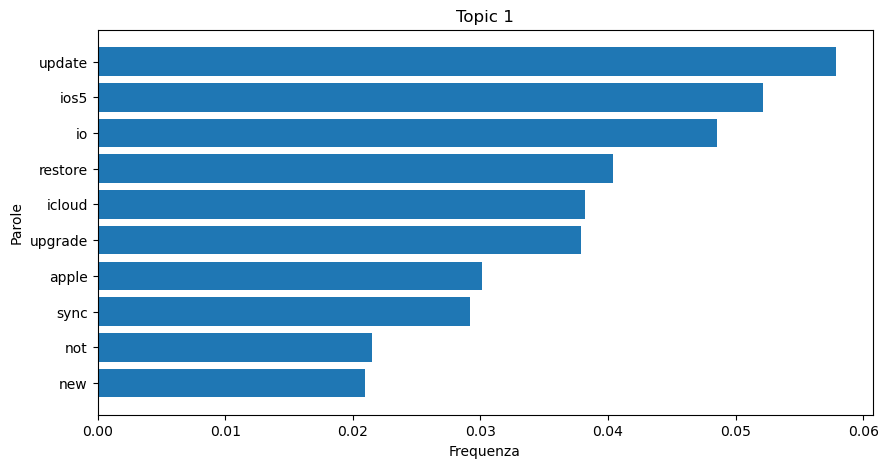

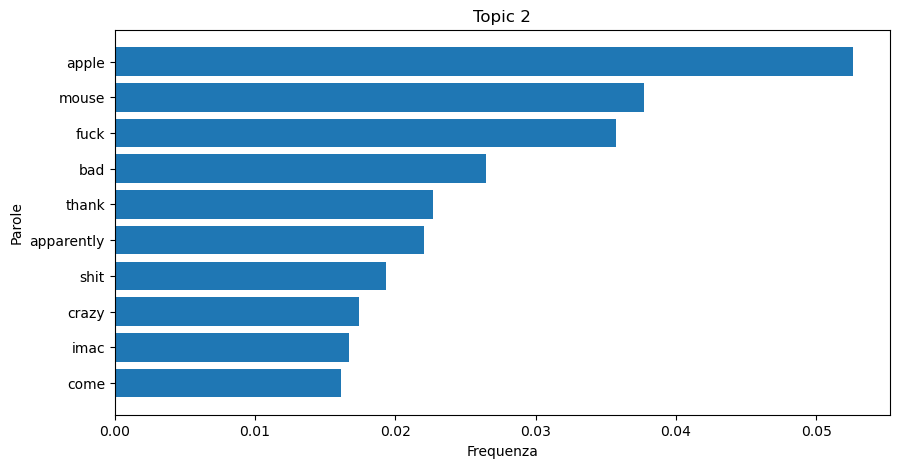

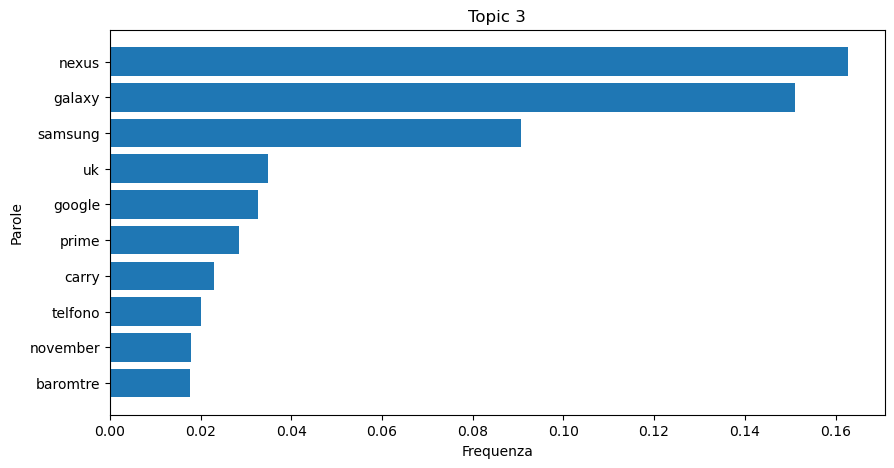

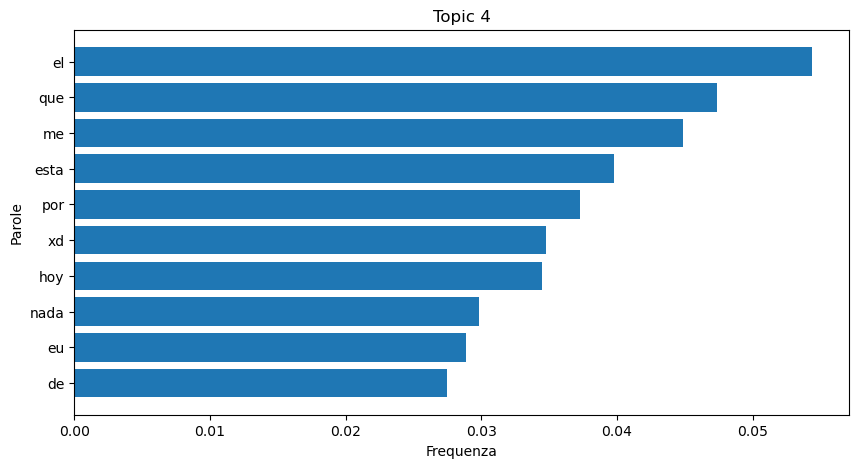

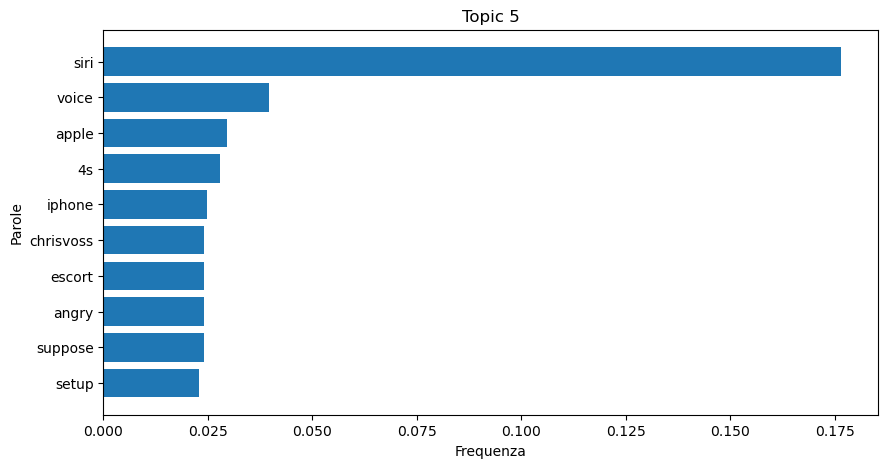

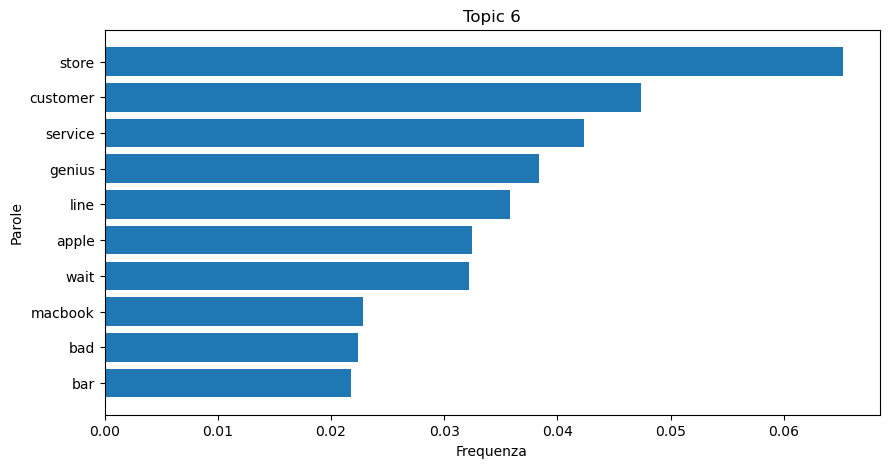

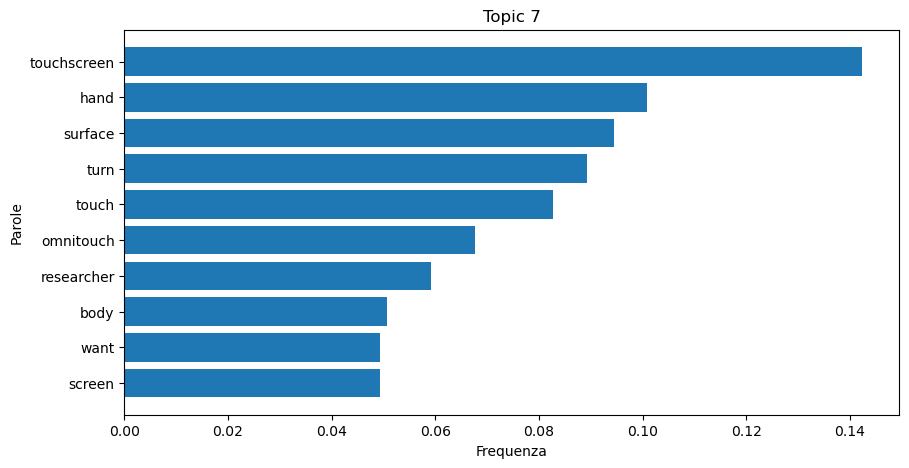

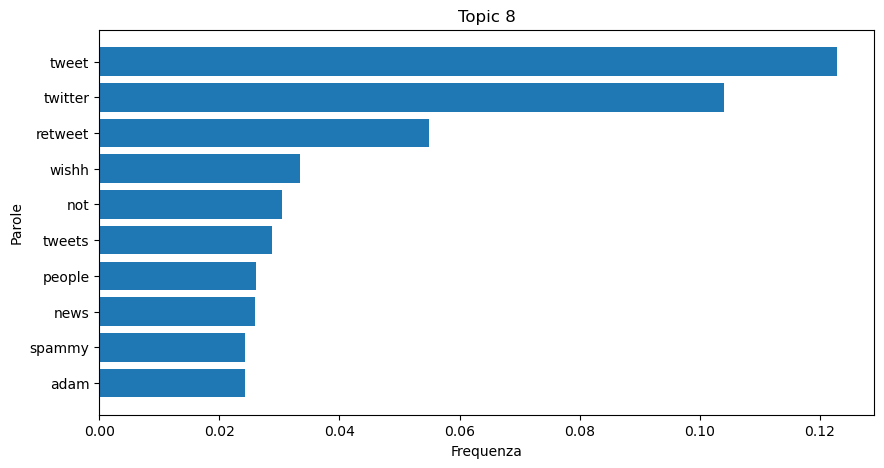

In [121]:
plot_topics(bert_topics)

In [122]:
from g2t.graph2topictm import Graph2TopicTM
from g2t.graph2topictm import _calculate_topic_diversity, _calculate_cv_npmi

tm = Graph2TopicTM(dataset=data_lemmatized, 
                embedding='princeton-nlp/unsup-simcse-bert-base-uncased')
g2T_prediction = tm.train()
g2T_topics = tm.get_topics()
print(f'Topics: {g2T_topics}')

# Evaluate
g2T_td = _calculate_topic_diversity(g2T_topics)
g2T_cv, g2T_npmi = _calculate_cv_npmi(data_lemmatized, g2T_prediction, g2T_topics)

# Print the results
print(f"Topic Diversity Score: {g2T_td}")
print(f"Coherence (c_v) Score: {g2T_cv}")
print(f"Coherence (NPMI) Score: {g2T_npmi}")

Initialize G2T with num_topics=10, embedding=princeton-nlp/unsup-simcse-bert-base-uncased, dim_size=5, graph_method=greedy_modularity
---creating embedding---


5062it [11:11,  7.54it/s]


---Detect 78 Topcis---
====== Using TFIDF_IDFi ======
Topics: {0: [('mas', 0.0048932107666582025), ('me', 0.004720839776169418), ('el', 0.004218760337254499), ('jajaja', 0.003990786109709938), ('si', 0.003699012052983511), ('que', 0.0036510521509014442), ('nuevo', 0.0036187093147079883), ('hoy', 0.0032775366216350665), ('en', 0.0030490149687995827), ('nueva', 0.0027946273207527083)], 1: [('rt', 0.009170658282222213), ('not', 0.008349107398069704), ('like', 0.005798491777767711), ('get', 0.005423930444133064), ('follow', 0.005312098685297791), ('lol', 0.004717604554428041), ('game', 0.004117647616073956), ('shit', 0.004055895550755367), ('fuck', 0.004042320402284534), ('got', 0.003994665496154714)], 2: [('ballmer', 0.01662093801592393), ('microsoft', 0.014620402710921175), ('ceo', 0.01176030189628526), ('lucky', 0.011429649754051054), ('steve', 0.008112595528840333), ('yahoo', 0.007525160227530911), ('cloud', 0.0071476209122817574), ('buying', 0.006720211569667358), ('buy', 0.0044555868

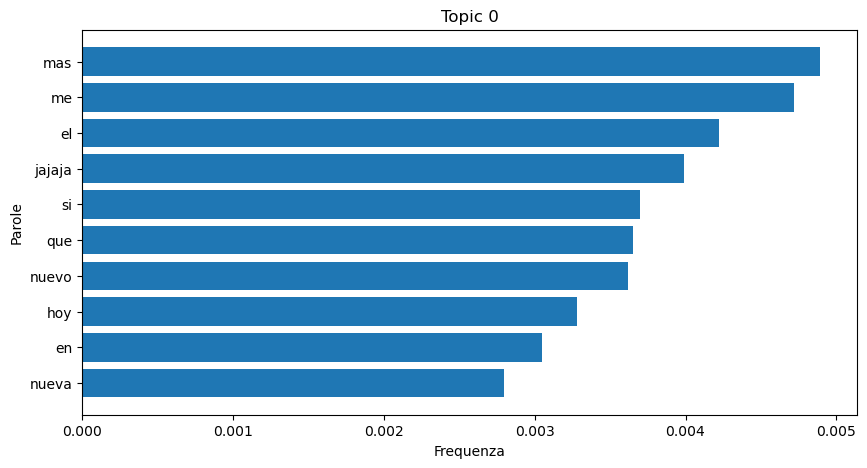

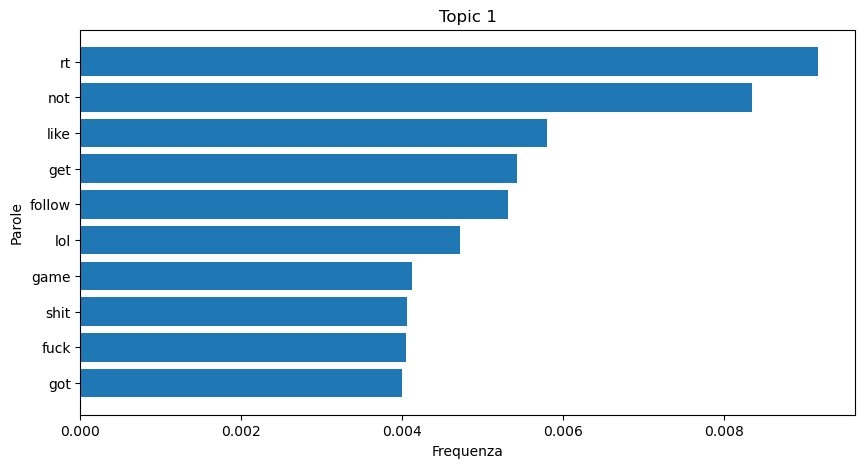

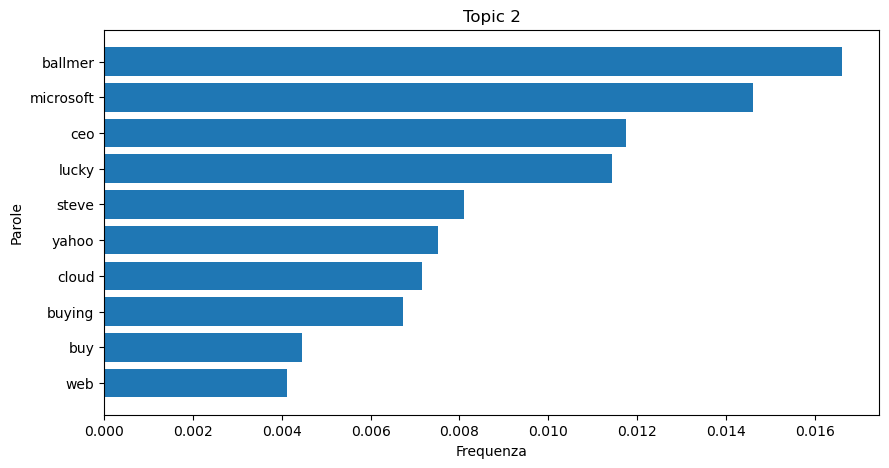

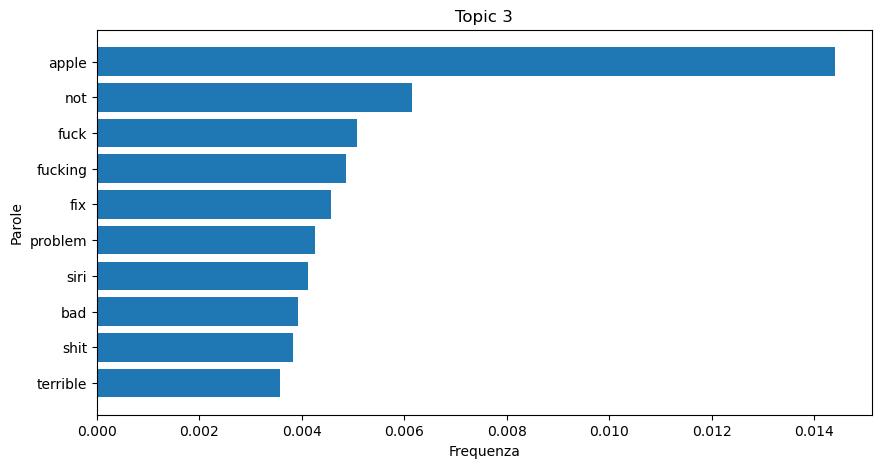

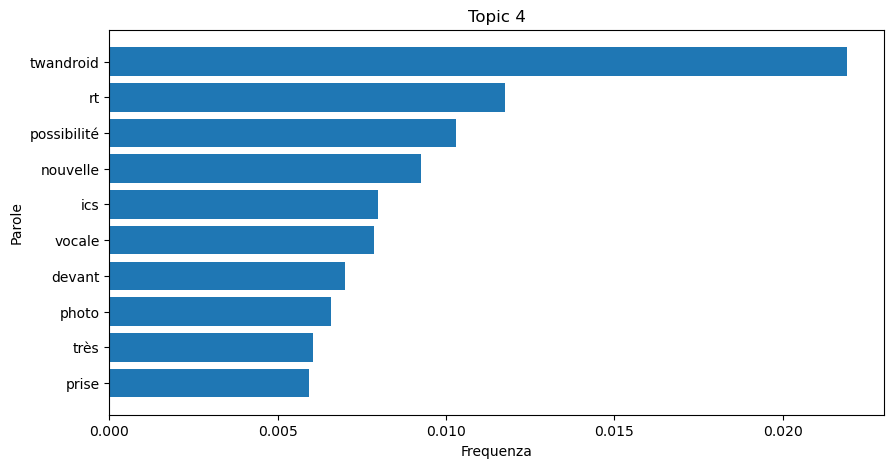

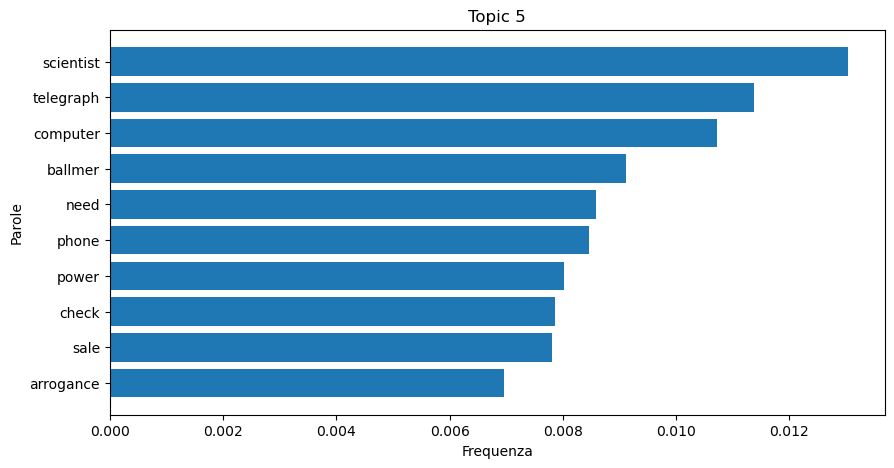

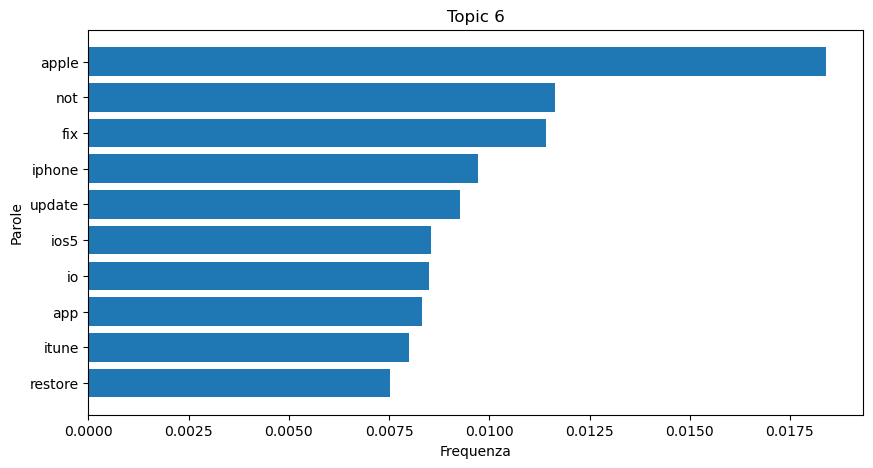

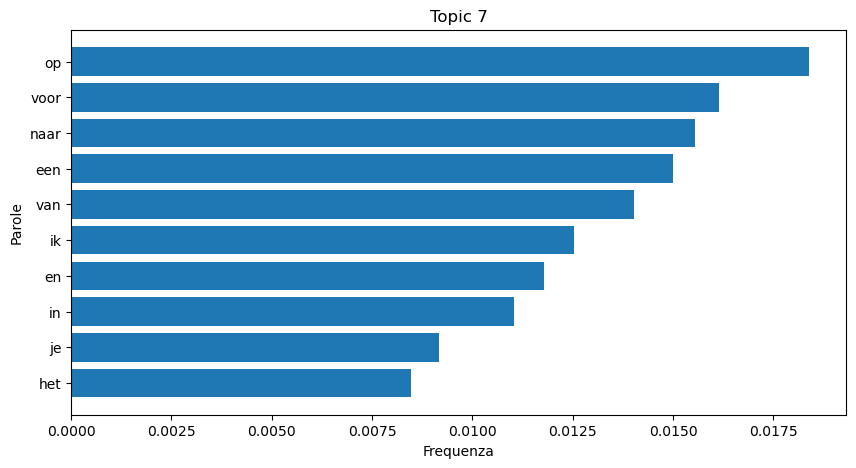

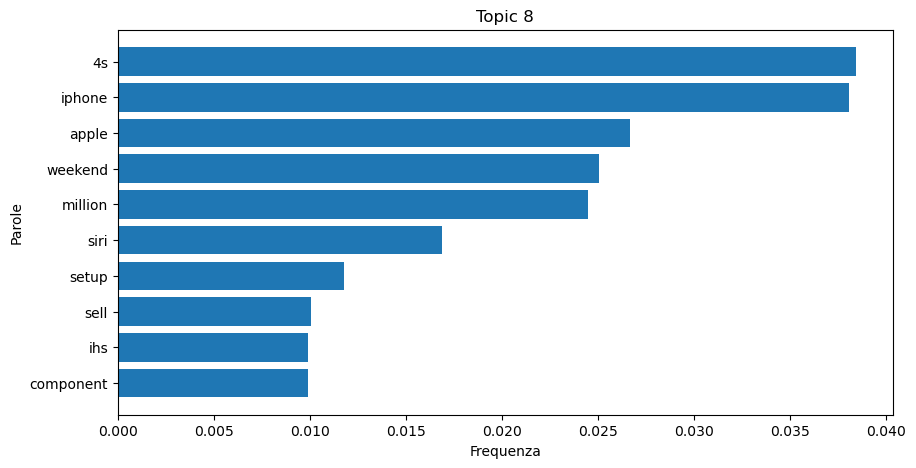

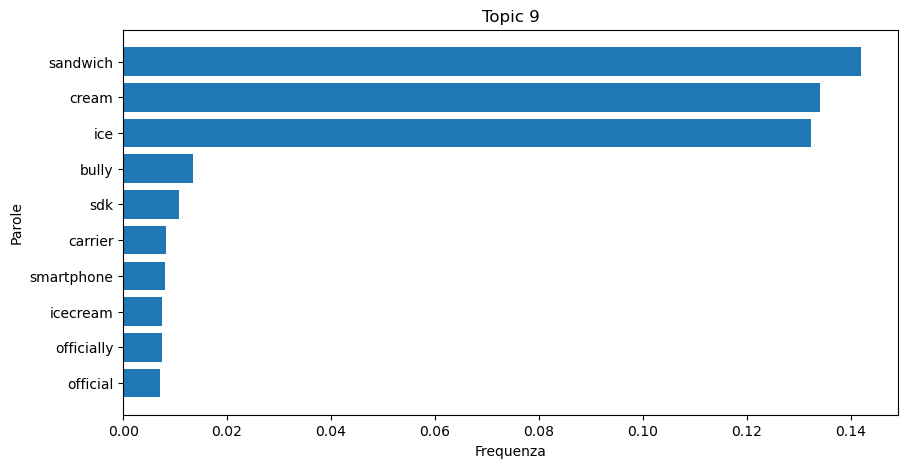

In [123]:
# Esegui la funzione per visualizzare i topic
plot_topics(g2T_topics)

In [124]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from pprint import pprint



# Funzione per convertire le frasi in parole
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))


# Accedi correttamente alla colonna
data_words = list(sent_to_words(data_lemmatized))


# Visualizza i primi 30 termini del primo documento
print(data_words[:1][0][:30])



['apple', 'swype', 'iphone', 'crack', 'iphone']


In [125]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Creare il corpus BoW
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, 1), (1, 1), (2, 2), (3, 1)]
[(0,
  '0.020*"apple" + 0.013*"nexus" + 0.011*"galaxy" + 0.011*"sandwich" + '
  '0.010*"new" + 0.010*"cream" + 0.009*"ice" + 0.008*"android" + '
  '0.008*"google" + 0.007*"rt"'),
 (1,
  '0.023*"rt" + 0.015*"apple" + 0.008*"google" + 0.008*"microsoft" + '
  '0.007*"get" + 0.006*"steve" + 0.006*"ballmer" + 0.006*"phone" + '
  '0.005*"android" + 0.005*"new"'),
 (2,
  '0.028*"apple" + 0.009*"nexus" + 0.009*"galaxy" + 0.009*"sandwich" + '
  '0.009*"cream" + 0.008*"ice" + 0.007*"not" + 0.006*"rt" + 0.005*"like" + '
  '0.005*"android"'),
 (3,
  '0.023*"apple" + 0.016*"rt" + 0.008*"phone" + 0.006*"iphone" + '
  '0.005*"google" + 0.005*"work" + 0.004*"not" + 0.004*"get" + 0.004*"siri" + '
  '0.003*"steve"'),
 (4,
  '0.046*"apple" + 0.008*"microsoft" + 0.007*"not" + 0.006*"rt" + '
  '0.006*"iphone" + 0.005*"new" + 0.004*"galaxy" + 0.004*"nexus" + '
  '0.004*"store" + 0.004*"go"'),
 (5,
  '0.039*"rt" + 0.016*"apple" + 0.010*"iphone" + 0.009*"not" + 0.005*"twitter"

In [126]:
predictions = []
for doc in corpus:
    topic_probs = lda_model.get_document_topics(doc)
    # Extract the topic with the highest probability
    # If no topic, assign -1
    if topic_probs:
        predictions.append(max(topic_probs, key=lambda x: x[1])[0])
    else:
        predictions.append(-1)

# Create a dictionary to map topics to words and their weights
lda_topics = {}
for topic_id in range(num_topics):
    words = lda_model.get_topic_terms(topic_id, topn=10)  # Get top 10 words for each topic
    lda_topics[topic_id] = [(id2word[word_id], weight) for word_id, weight in words]

td_lda, cv_lda, npmi_lda = evaluate(data_lemmatized, predictions, lda_topics)
print(f"Diversità dei temi: {td_lda}, Coerenza c_v: {cv_lda}, Coerenza NPMI: {npmi_lda}")

Diversità dei temi: 0.31, Coerenza c_v: 0.43920803412874243, Coerenza NPMI: -0.0005568422333636266


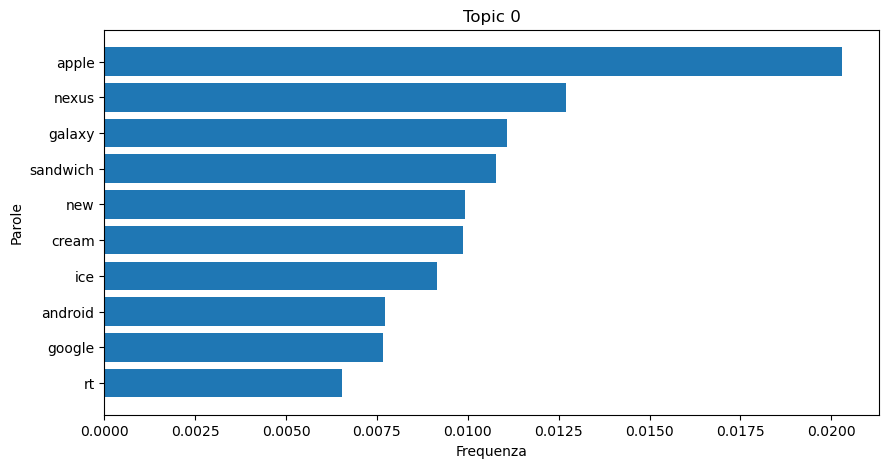

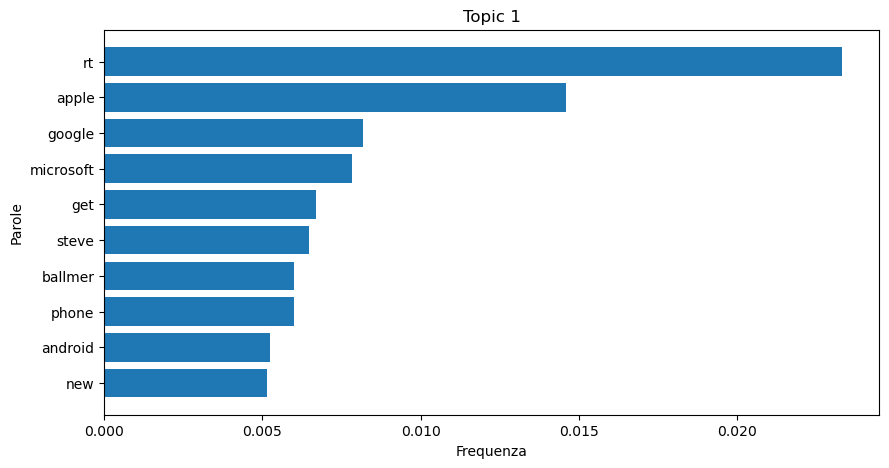

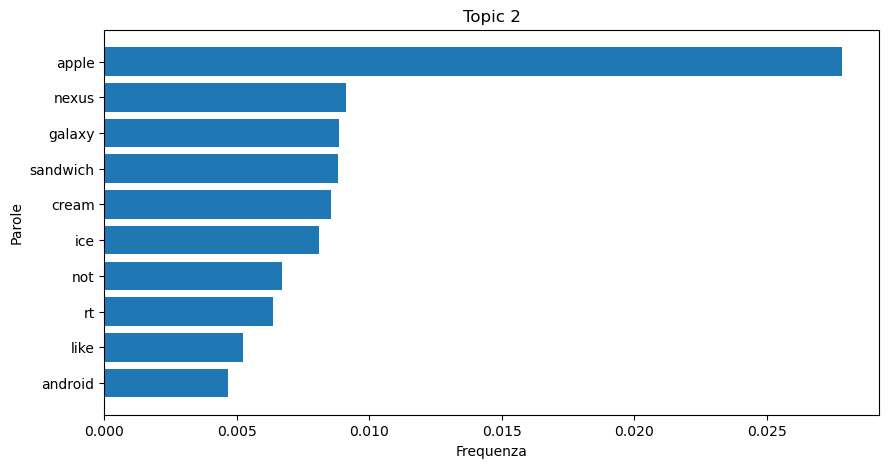

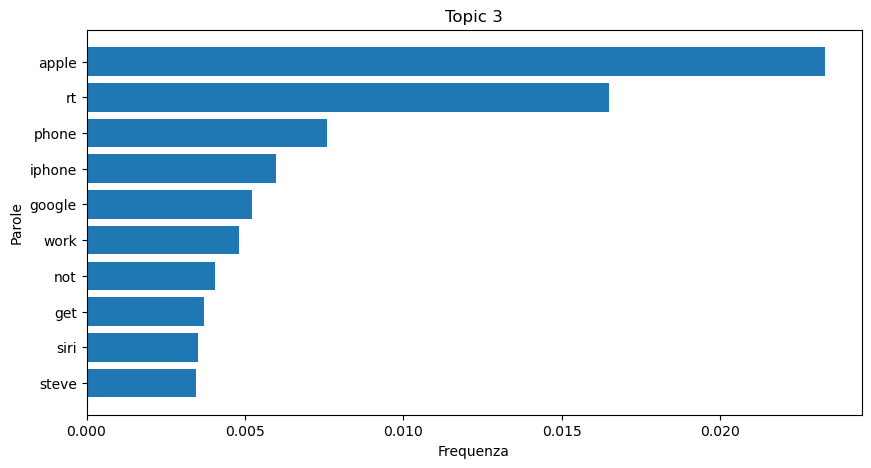

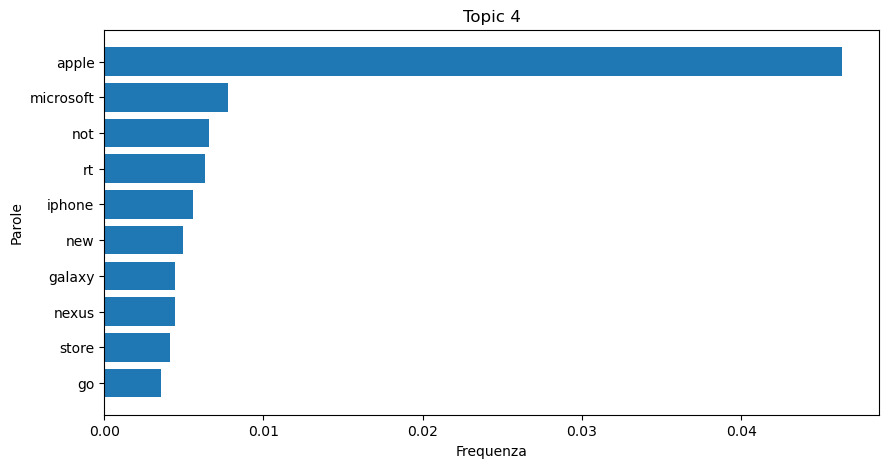

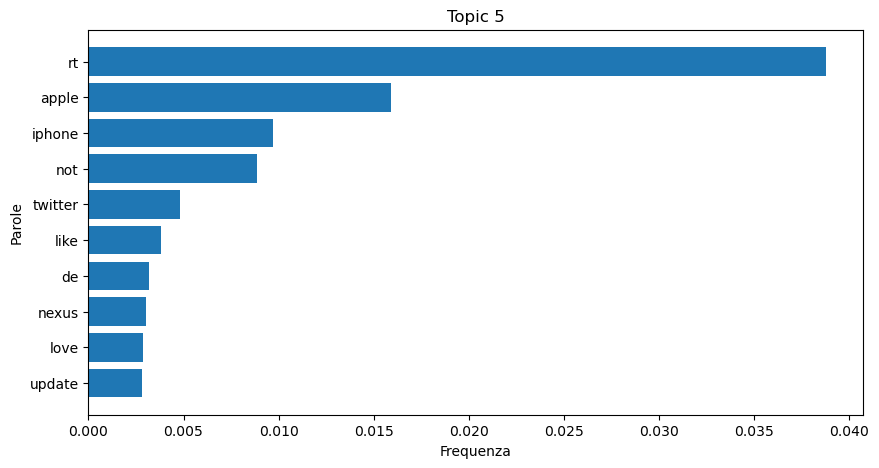

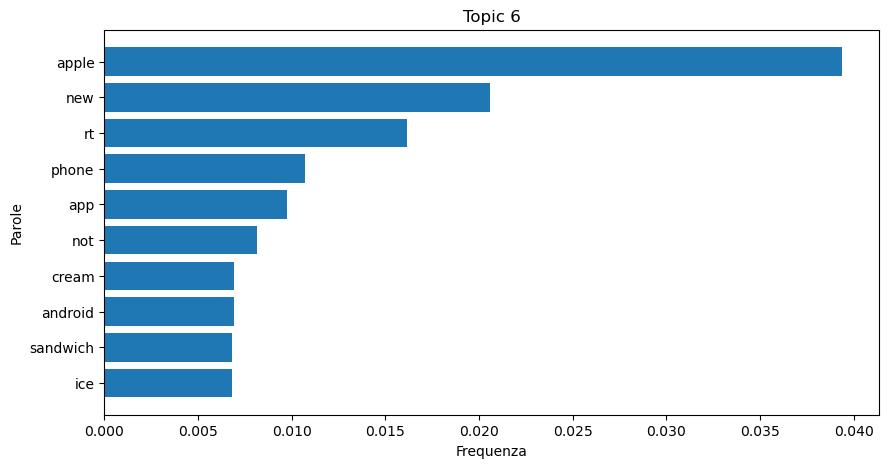

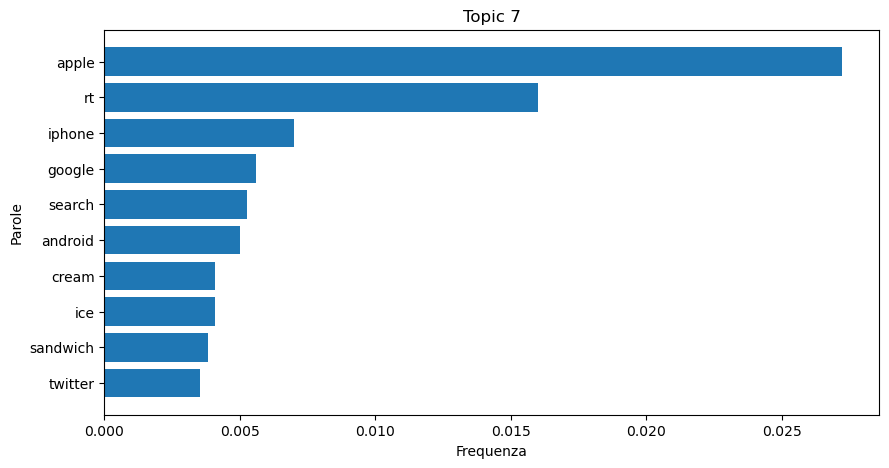

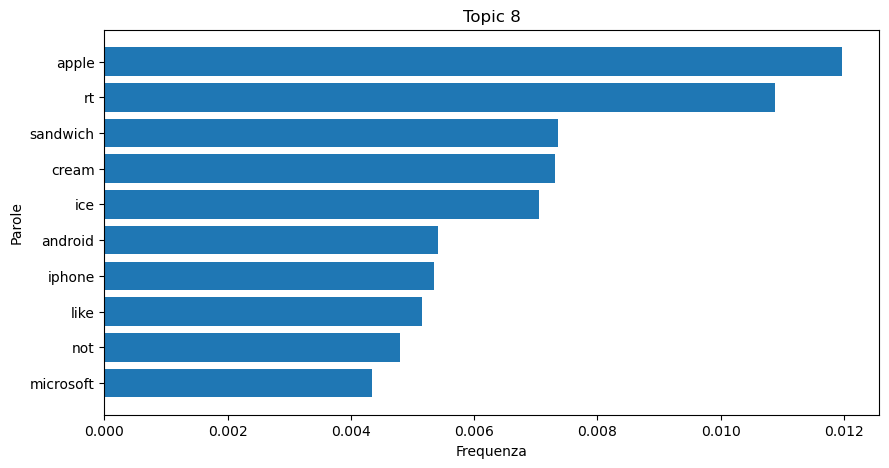

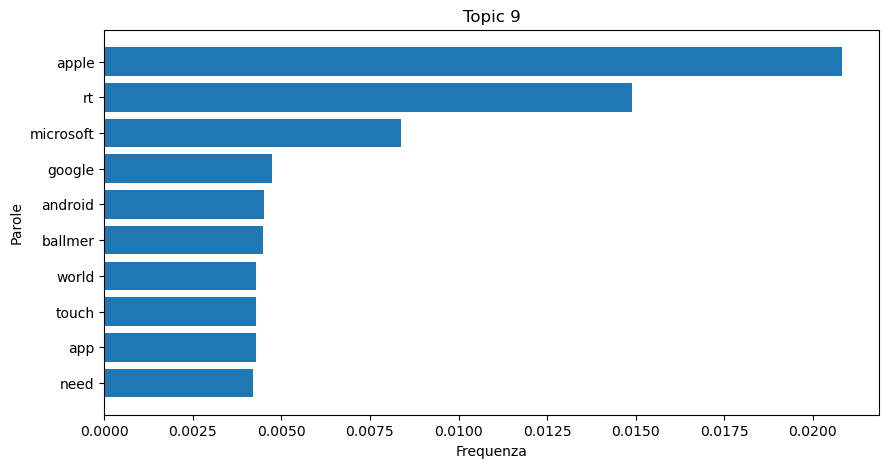

In [127]:
plot_topics(lda_topics)


In [128]:
import Bert_LDA
import importlib  # Importa importlib
importlib.reload(Bert_LDA) 

<module 'Bert_LDA' from '/Users/hongyuxu/Downloads/implementazioni Topic/Bert_LDA.py'>

In [129]:
from Bert_LDA import Topic_Model
from Bert_LDA import get_token_lists

token_lists = get_token_lists(data_lemmatized)
l_b_tm = Topic_Model(method='LDA_BERT')
l_b_tm.fit(data_lemmatized, token_lists)

Clustering embeddings ...
Getting vector representations for LDA ...
Getting vector representations for LDA. Done!
Getting vector representations for BERT ...


Batches:   0%|          | 0/159 [00:00<?, ?it/s]

Getting vector representations for BERT. Done!
Fitting Autoencoder ...
Fitting Autoencoder Done!
159/159 [==============================] - 1s 3ms/step
Clustering embeddings. Done!


In [130]:
import Bert_LDA
import importlib  # Importa importlib
importlib.reload(Bert_LDA) 

<module 'Bert_LDA' from '/Users/hongyuxu/Downloads/implementazioni Topic/Bert_LDA.py'>

In [131]:
from Bert_LDA import get_topic_words
predictions_ldaB = l_b_tm.predict(data_lemmatized)

LDABtopics = get_topic_words(token_lists, predictions_ldaB)
topics_dict = {i: topic for i, topic in enumerate(LDABtopics)}



In [132]:
td_ldaBERT, cv_ldaBERT, npmi_ldaBERT = evaluate(data_lemmatized, predictions, topics_dict)
print(f"Diversità dei temi: {td_ldaBERT}, Coerenza c_v: {cv_ldaBERT}, Coerenza NPMI: {npmi_ldaBERT}")

Diversità dei temi: 0.65, Coerenza c_v: 0.39096317310650425, Coerenza NPMI: -0.055538433302823854


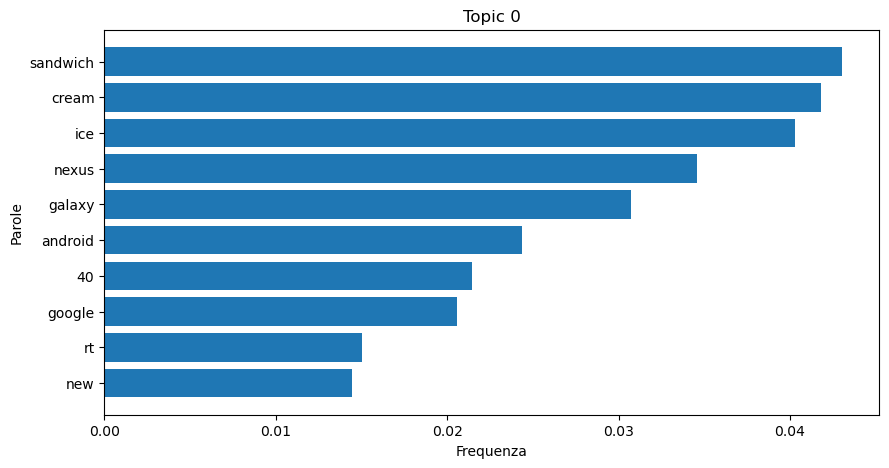

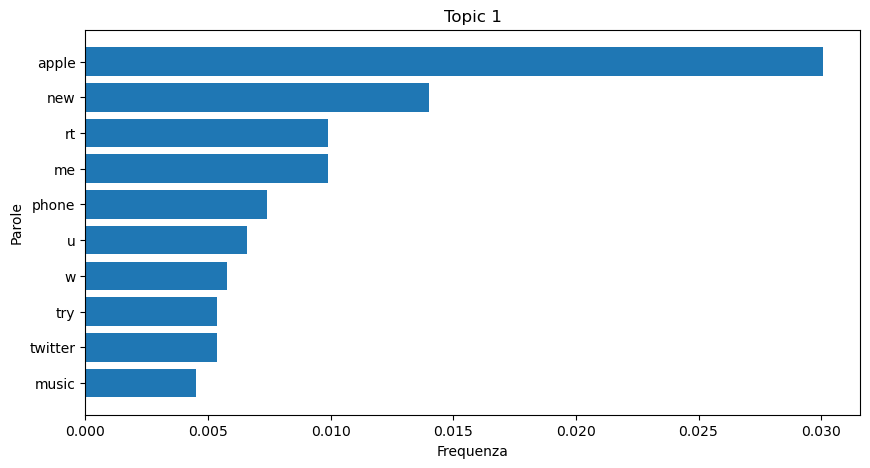

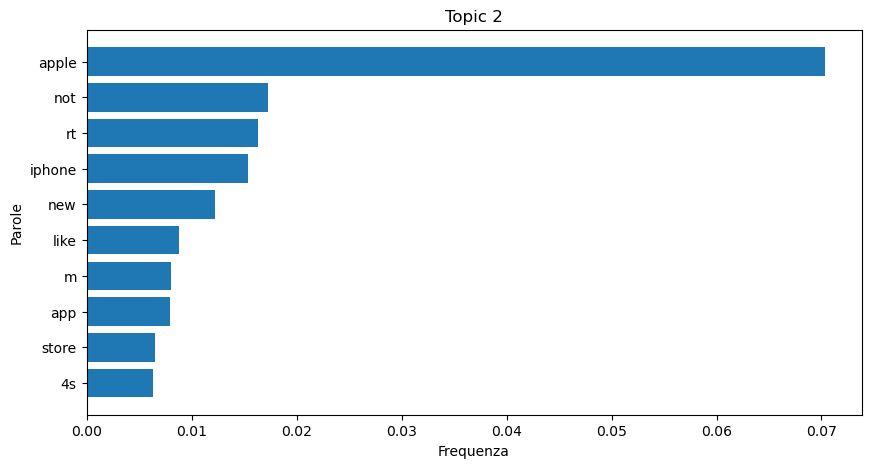

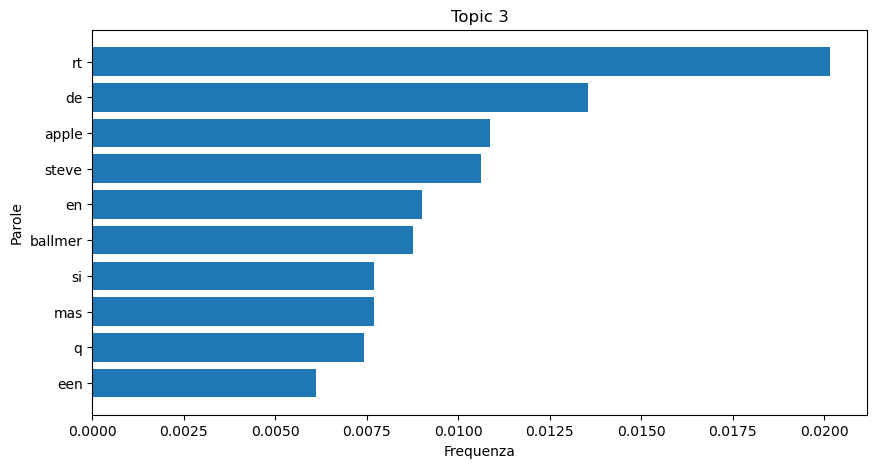

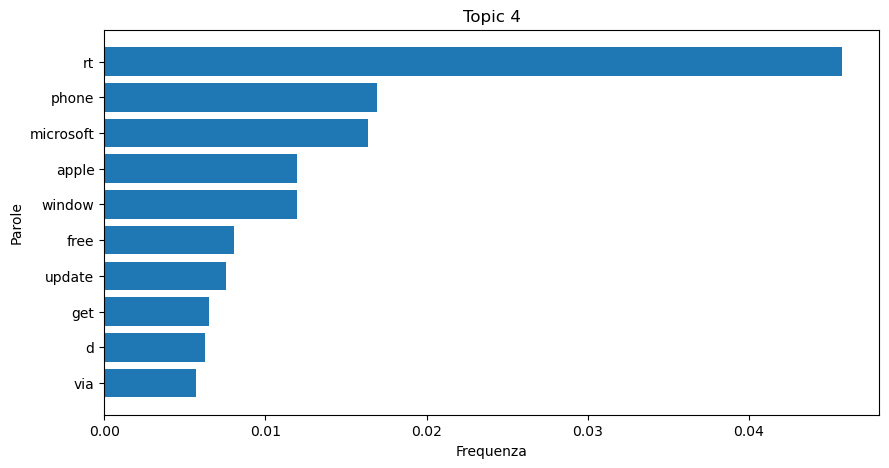

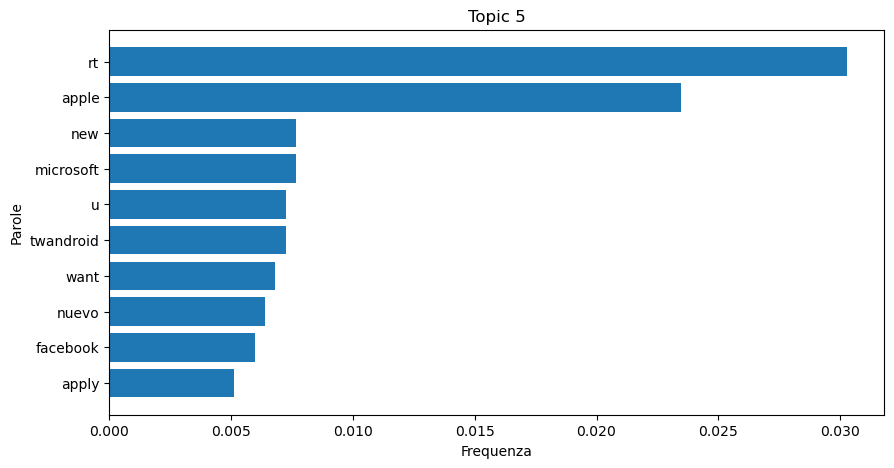

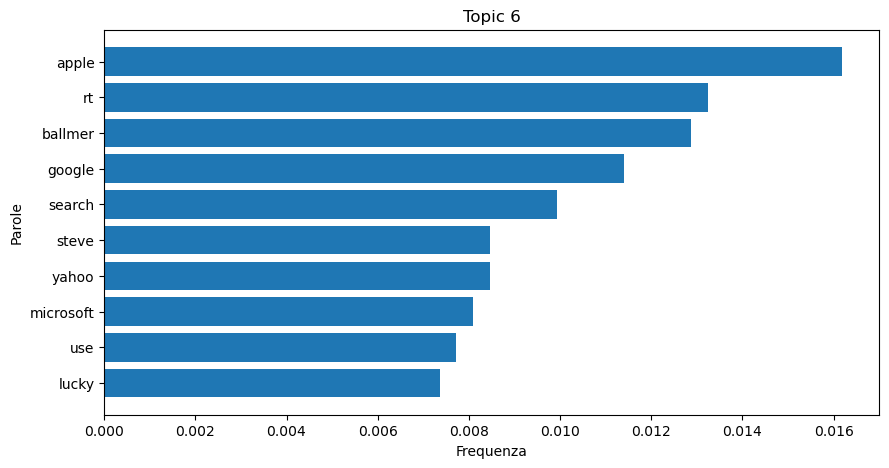

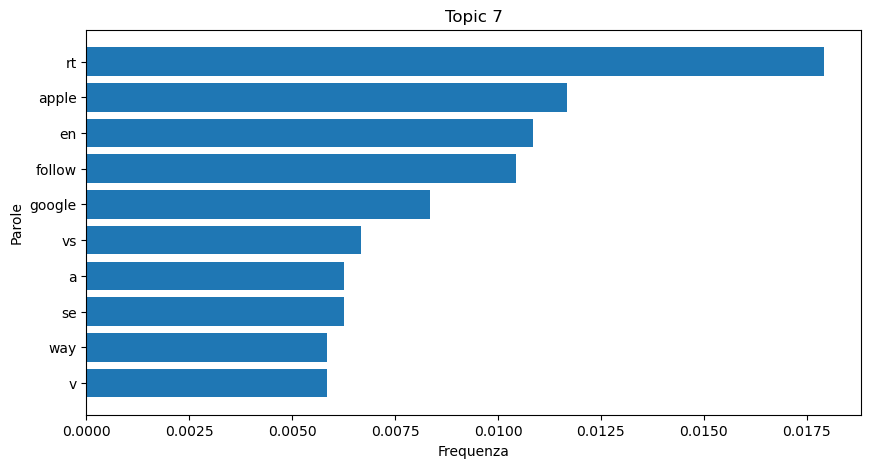

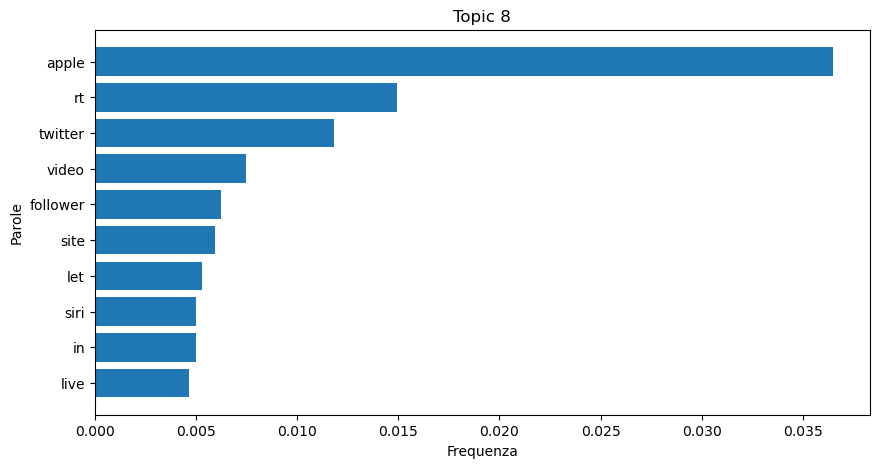

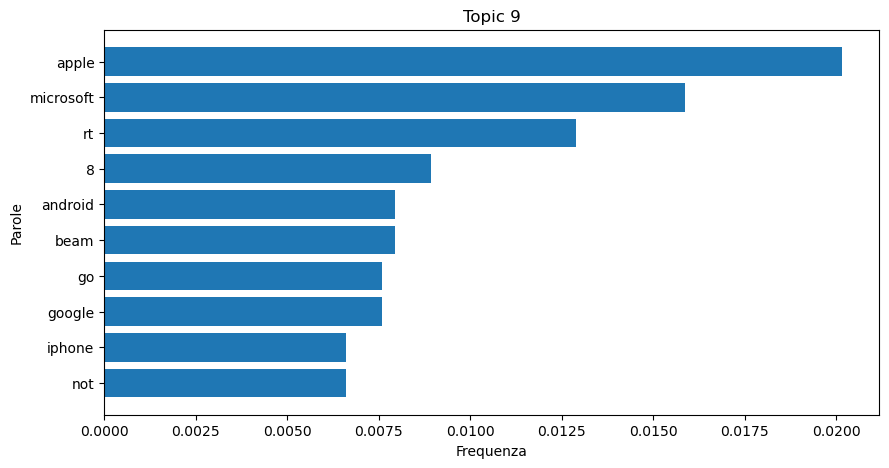

In [133]:
plot_topics(topics_dict)

In [134]:
data = {
    'LDA_BERT': [td_ldaBERT, cv_ldaBERT, npmi_ldaBERT],
    'Graph2Topic': [g2T_td, g2T_cv, g2T_npmi],
    'BERTopic': [td_score, cv_score, npmi_score],
    'LDA' : [td_lda, cv_lda, npmi_lda]
}

# Creazione del DataFrame e impostazione delle righe
df = pd.DataFrame(data, index=['td', 'cv', 'npmi'])

# Visualizzazione della tabella
df


,LDA_BERT,Graph2Topic,BERTopic,LDA
td,0.650000,0.880000,0.860825,0.310000
cv,0.390963,0.801744,0.791946,0.439208
npmi,-0.055538,0.091724,0.152973,-0.000557


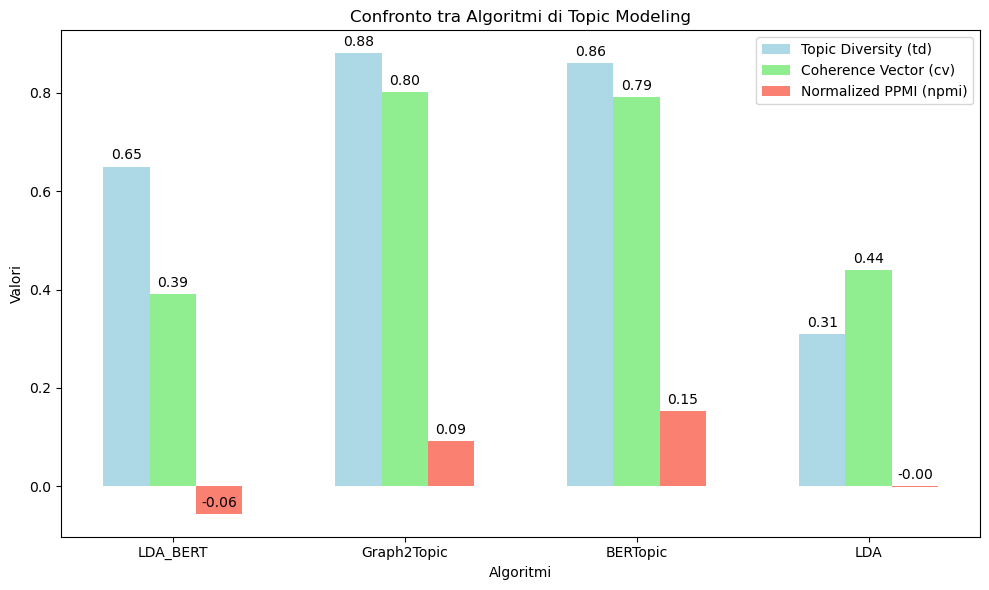

In [135]:
import matplotlib.pyplot as plt
import numpy as np

# Definisco i dati
algorithms = ['LDA_BERT', 'Graph2Topic', 'BERTopic', 'LDA']
td = [td_ldaBERT, g2T_td, td_score, td_lda]
cv = [cv_ldaBERT, g2T_cv, cv_score, cv_lda]
npmi = [npmi_ldaBERT, g2T_npmi, npmi_score, npmi_lda]

# Posizioni delle barre
x = np.arange(len(algorithms))

# Larghezza delle barre
width = 0.2

# Creazione della figura e degli assi
fig, ax = plt.subplots(figsize=(10, 6))

# Creazione delle barre
bars1 = ax.bar(x - width, td, width, label='Topic Diversity (td)', color='lightblue')
bars2 = ax.bar(x, cv, width, label='Coherence Vector (cv)', color='lightgreen')
bars3 = ax.bar(x + width, npmi, width, label='Normalized PPMI (npmi)', color='salmon')

# Aggiunta delle etichette e titolo
ax.set_xlabel('Algoritmi')
ax.set_ylabel('Valori')
ax.set_title('Confronto tra Algoritmi di Topic Modeling')
ax.set_xticks(x)
ax.set_xticklabels(algorithms)
ax.legend()

# Aggiunta delle etichette sopra le barre
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 punti sopra la barra
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

# Mostrare il grafico
plt.tight_layout()
plt.show()
